In [ ]:
import torch
import torchvision
from torch import optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
trainset = datasets.CIFAR10('cifar',
            train=True, download=True,
            transform=transforms.Compose([
                transforms.Resize((32, 32)),
                transforms.ToTensor()
            ]))

testset = datasets.CIFAR10('cifar', False,
                          transform = transforms.Compose([
                              transforms.Resize((32, 32)),
                              transforms.ToTensor()
                          ]))

trainset = DataLoader(trainset, batch_size=32, shuffle=True)
testset = DataLoader(testset, batch_size=32, shuffle=True)

100%|██████████| 170498071/170498071 [00:05<00:00, 32739339.38it/s]


Extracting cifar/cifar-10-python.tar.gz to cifar


**Define the Resnet and the Classifier**

In [ ]:
class Block(nn.Module):
    def __init__(self, num_layers, in_channels, out_channels, identity_downsample=None, stride=1):
        assert num_layers in [18, 34, 50, 101, 152], "should be a a valid architecture"
        super(Block, self).__init__()
        self.num_layers = num_layers
        if self.num_layers > 34:
            self.expansion = 4
        else:
            self.expansion = 1
        # ResNet50, 101, and 152 include additional layer of 1x1 kernels
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        if self.num_layers > 34:
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        else:
            # for ResNet18 and 34, connect input directly to (3x3) kernel (skip first (1x1))
            self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        if self.num_layers > 34:
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x

In [ ]:
class ResNet(nn.Module):
    def __init__(self, num_layers, block, image_channels, num_classes):
        assert num_layers in [18, 34, 50, 101, 152], f'ResNet{num_layers}: Unknown architecture! Number of layers has ' \
                                                     f'to be 18, 34, 50, 101, or 152 '
        super(ResNet, self).__init__()
        if num_layers < 50:
            self.expansion = 1
        else:
            self.expansion = 4
        if num_layers == 18:
            layers = [2, 2, 2, 2]
        elif num_layers == 34 or num_layers == 50:
            layers = [3, 4, 6, 3]
        elif num_layers == 101:
            layers = [3, 4, 23, 3]
        else:
            layers = [3, 8, 36, 3]
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Scaling Parameter
        self.init_scaling_factor = torch.ones(num_classes)
        self.scaling_factor = torch.nn.Parameter(self.init_scaling_factor, requires_grad=True)

        # ResNetLayers
        self.layer1 = self.make_layers(num_layers, block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self.make_layers(num_layers, block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self.make_layers(num_layers, block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self.make_layers(num_layers, block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * self.expansion, num_classes)

        # softmax layer
        # self.softmax = torch.nn.Softmax()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)/self.scaling_factor
        return x

    def make_layers(self, num_layers, block, num_residual_blocks, intermediate_channels, stride):
        layers = []

        identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, intermediate_channels*self.expansion, kernel_size=1, stride=stride),
                                            nn.BatchNorm2d(intermediate_channels*self.expansion))
        layers.append(block(num_layers, self.in_channels, intermediate_channels, identity_downsample, stride))
        self.in_channels = intermediate_channels * self.expansion # 256
        for i in range(num_residual_blocks - 1):
            layers.append(block(num_layers, self.in_channels, intermediate_channels)) # 256 -> 64, 64*4 (256) again
        return nn.Sequential(*layers)

In [ ]:
"""
 Defined various architectures of Resnet
"""

def ResNet18(img_channels=3, num_classes=1000):
    return ResNet(18, Block, img_channels, num_classes)
def ResNet34(img_channels=3, num_classes=1000):
    return ResNet(34, Block, img_channels, num_classes)
def ResNet50(img_channels=3, num_classes=1000):
    return ResNet(50, Block, img_channels, num_classes)
def ResNet101(img_channels=3, num_classes=1000):
    return ResNet(101, Block, img_channels, num_classes)
def ResNet152(img_channels=3, num_classes=1000):
    return ResNet(152, Block, img_channels, num_classes)

def test():
    net = ResNet18(img_channels=3, num_classes=1000)
    y = net(torch.randn(4, 3, 224, 224)).to("cuda")
    print(y.size())

**Train the model**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Detected device=>{device}, putting model to {device}")
model = ResNet18(img_channels=3, num_classes=10).to(device)
model

Detected device=>cuda, putting model to cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def compute_acc_bin(conf_thresh_lower, conf_thresh_upper, conf, pred, true):
    """
    # Computes accuracy and average confidence for bin

    Args:
        conf_thresh_lower (float): Lower Threshold of confidence interval
        conf_thresh_upper (float): Upper Threshold of confidence interval
        conf (numpy.ndarray): list of confidences
        pred (numpy.ndarray): list of predictions
        true (numpy.ndarray): list of true labels

    Returns:
        (accuracy, avg_conf, len_bin): accuracy of bin, confidence of bin and number of elements in bin.
    """
    filtered_tuples = [x for x in zip(pred, true, conf) if x[2] > conf_thresh_lower and x[2] <= conf_thresh_upper]
    if len(filtered_tuples) < 1:
        return 0,0,0
    else:
        correct = len([x for x in filtered_tuples if x[0] == x[1]])  # How many correct labels
        len_bin = len(filtered_tuples)  # How many elements falls into given bin
        avg_conf = sum([x[2] for x in filtered_tuples]) / len_bin  # Avg confidence of BIN
        accuracy = float(correct)/len_bin  # accuracy of BIN
        return accuracy, avg_conf, len_bin


def ECE(conf, pred, true, bin_size = 0.1):
    """
    Expected Calibration Error

    Args:
        conf (numpy.ndarray): list of confidences
        pred (numpy.ndarray): list of predictions
        true (numpy.ndarray): list of true labels
        bin_size: (float): size of one bin (0,1)  # TODO should convert to number of bins?

    Returns:
        ece: expected calibration error
    """

    upper_bounds = np.arange(bin_size, 1+bin_size, bin_size)  # Get bounds of bins

    n = len(conf)
    ece = 0  # Starting error

    for conf_thresh in upper_bounds:  # Go through bounds and find accuracies and confidences
        acc, avg_conf, len_bin = compute_acc_bin(conf_thresh-bin_size, conf_thresh, conf, pred, true)
        ece += np.abs(acc-avg_conf)*len_bin/n  # Add weigthed difference to ECE

    return ece


def get_bin_info(conf, pred, true, bin_size = 0.1):
    """
    Get accuracy, confidence and elements in bin information for all the bins.

    Args:
        conf (numpy.ndarray): list of confidences
        pred (numpy.ndarray): list of predictions
        true (numpy.ndarray): list of true labels
        bin_size: (float): size of one bin (0,1)  # TODO should convert to number of bins?

    Returns:
        (acc, conf, len_bins): tuple containing all the necessary info for reliability diagrams.
    """

    upper_bounds = np.arange(bin_size, 1+bin_size, bin_size)

    accuracies = []
    confidences = []
    bin_lengths = []

    for conf_thresh in upper_bounds:
        acc, avg_conf, len_bin = compute_acc_bin(conf_thresh-bin_size, conf_thresh, conf, pred, true)
        accuracies.append(acc)
        confidences.append(avg_conf)
        bin_lengths.append(len_bin)


    return accuracies, confidences, bin_lengths

# reliability diagram plotting for subplot case.
def rel_diagram_sub(accs, confs, M = 10, name = "Reliability Diagram", xname = "Confidence", yname="Accuracy",save_name=""):
    acc_conf = np.column_stack([accs,confs])
    acc_conf.sort(axis=1)
    outputs = acc_conf[:, 0]
    gap = acc_conf[:, 1]

    bin_size = 1/M
    positions = np.arange(0+bin_size/2, 1+bin_size/2, bin_size)

    # Plot gap first, so its below everything
    gap_plt = plt.bar(positions, gap, width = bin_size, edgecolor = "red", color = "red", alpha = 0.3, label="Gap", linewidth=2, zorder=2)

    # Next add error lines
    #for i in range(M):
        #plt.plot([i/M,1], [0, (M-i)/M], color = "red", alpha=0.5, zorder=1)

    #Bars with outputs
    output_plt = plt.bar(positions, outputs, width = bin_size, edgecolor = "black", color = "blue", label="Outputs", zorder = 3)

    # Line plot with center line.
    plt.gca().set_aspect('equal')
    plt.plot([0,1], [0,1], linestyle = "--")
    plt.legend(handles = [gap_plt, output_plt])
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.title(f"{name}-{save_name.split('.')[0]}", fontsize=24)
    plt.xlabel(xname, fontsize=22, color = "black")
    plt.ylabel(yname, fontsize=22, color = "black")
    plt.savefig(f'/content/drive/MyDrive/Projects/Temperature Scaling of NN/{save_name}', dpi=300)

In [ ]:
%%time
from tqdm import tqdm

num_epochs = 15
# track training metrics
loss_li,acc_li, epoch_error  = [], [], []
# track calibration metrics
conf, prediction, true = list(), list(), list()

for epoch in range(num_epochs):
    for idx, (x, label) in tqdm(enumerate(trainset),desc=f"Epoch {epoch+1}"):
        x, label = x.to(device), label.to(device)
        #print(x.shape, label.shape)
        logits = model(x) # b [b, 10]
        loss = criterion(logits, label) # label: [b]
        # backprop
        optimizer.zero_grad()
        loss.backward()
        # gradient descent
        optimizer.step()
        # mapping the temperature to T>0 range
        model.scaling_factor.data.clamp_(min=0,max=float('Inf'))

    model.eval()
    with torch.no_grad():
        tot_corr = 0
        tot_num = 0
        epoch_calib_error = 0
        for x, label in testset:
            x, label = x.to(device), label.to(device)
            true.append(label.detach().cpu().numpy())
            logits = model(x)
            pred = logits.argmax(dim=1)
            conf.append(
                logits.softmax(dim=1).max(dim=1).values.detach().cpu().numpy()
                )
            prediction.append(pred.detach().cpu().numpy())
            # calculate the expected calibration error for the current batch
            batch_calib_error = ECE(conf=logits.softmax(dim=1).max(dim=1).values.detach().cpu().numpy(),
                                    pred=pred,true=label)
            epoch_calib_error = epoch_calib_error + batch_calib_error
            # using item() to convert tensor to number
            tot_corr += torch.eq(pred, label).float().sum().item()
            tot_num += x.size(0)
        acc = tot_corr / tot_num

    loss_li.append(loss.item())
    acc_li.append(acc)
    epoch_error.append(epoch_calib_error)
    print('epoch: {}, loss: {}, acc: {}, error: {}'.format(epoch+1, loss, acc, epoch_calib_error))
    # break

Epoch 1: 1563it [00:28, 55.04it/s]


epoch: 1, loss: 0.7513728141784668, acc: 0.4709, error: 60.7191092222929


Epoch 2: 1563it [00:26, 58.74it/s]


epoch: 2, loss: 1.3090829849243164, acc: 0.6144, error: 50.556511249393225


Epoch 3: 1563it [00:25, 60.77it/s]


epoch: 3, loss: 1.0116682052612305, acc: 0.6536, error: 50.40081034321338


Epoch 4: 1563it [00:26, 59.96it/s]


epoch: 4, loss: 0.5920493006706238, acc: 0.6661, error: 50.75904483301565


Epoch 5: 1563it [00:25, 60.51it/s]


epoch: 5, loss: 1.051808476448059, acc: 0.6829, error: 51.47107971319929


Epoch 6: 1563it [00:25, 60.54it/s]


epoch: 6, loss: 0.4274664521217346, acc: 0.6897, error: 49.9887019880116


Epoch 7: 1563it [00:25, 61.03it/s]


epoch: 7, loss: 0.40943893790245056, acc: 0.7159, error: 48.09677005978301


Epoch 8: 1563it [00:26, 58.88it/s]


epoch: 8, loss: 0.4704873263835907, acc: 0.7004, error: 48.97743864543736


Epoch 9: 1563it [00:26, 59.39it/s]


epoch: 9, loss: 0.5670832991600037, acc: 0.7139, error: 50.16418040078133


Epoch 10: 1563it [00:29, 52.34it/s]


epoch: 10, loss: 0.4579943120479584, acc: 0.7062, error: 53.152570620179176


Epoch 11: 1563it [00:25, 60.16it/s]


epoch: 11, loss: 0.680362343788147, acc: 0.7136, error: 55.257003591395915


Epoch 12: 1563it [00:26, 58.28it/s]


epoch: 12, loss: 0.3431800305843353, acc: 0.7152, error: 57.012964070774615


Epoch 13: 1563it [00:25, 60.25it/s]


epoch: 13, loss: 0.6588695049285889, acc: 0.7204, error: 56.15162214823067


Epoch 14: 1563it [00:25, 60.70it/s]


epoch: 14, loss: 0.2752910852432251, acc: 0.7199, error: 59.24894770607352


Epoch 15: 1563it [00:27, 57.54it/s]


epoch: 15, loss: 0.1412649005651474, acc: 0.7079, error: 61.25200780900195
CPU times: user 7min 20s, sys: 3.48 s, total: 7min 23s
Wall time: 7min 32s


In [ ]:
print("Temperature vector after scaling:", model.scaling_factor.detach().cpu().numpy())
print("Norm of the temperature vector after scaling is:",np.linalg.norm(model.scaling_factor.detach().cpu().numpy()))

Temperature vector after scaling: [1.5115422 1.4086698 1.6011121 1.6066947 1.529025  1.5378963 1.485671
 1.5171324 1.4492484 1.4634966]
Norm of the temperature vector after scaling is: 4.782074


In [ ]:
conf = [j for i in conf for j in i]
prediction = [j for i in prediction for j in i]
true = [j for i in true for j in i]
_acc, _confs, _ = get_bin_info(conf,prediction,true)

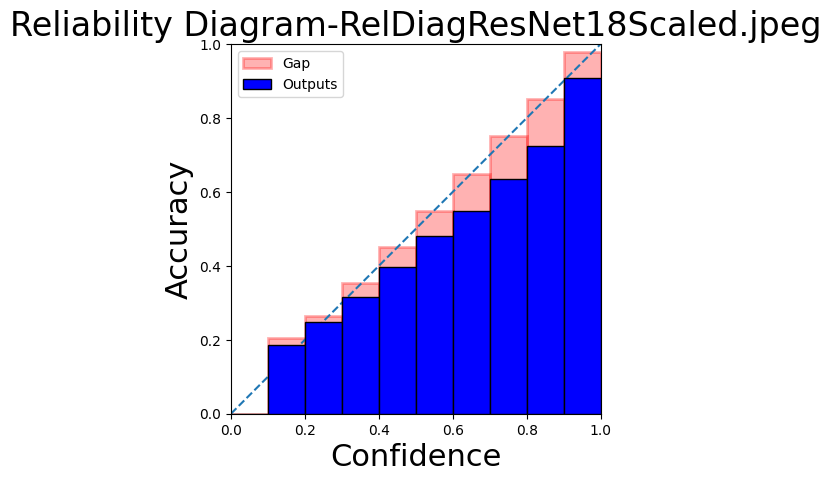

In [ ]:
rel_diagram_sub(_acc,_confs,save_name="RelDiagResNet18Scaled.jpeg")

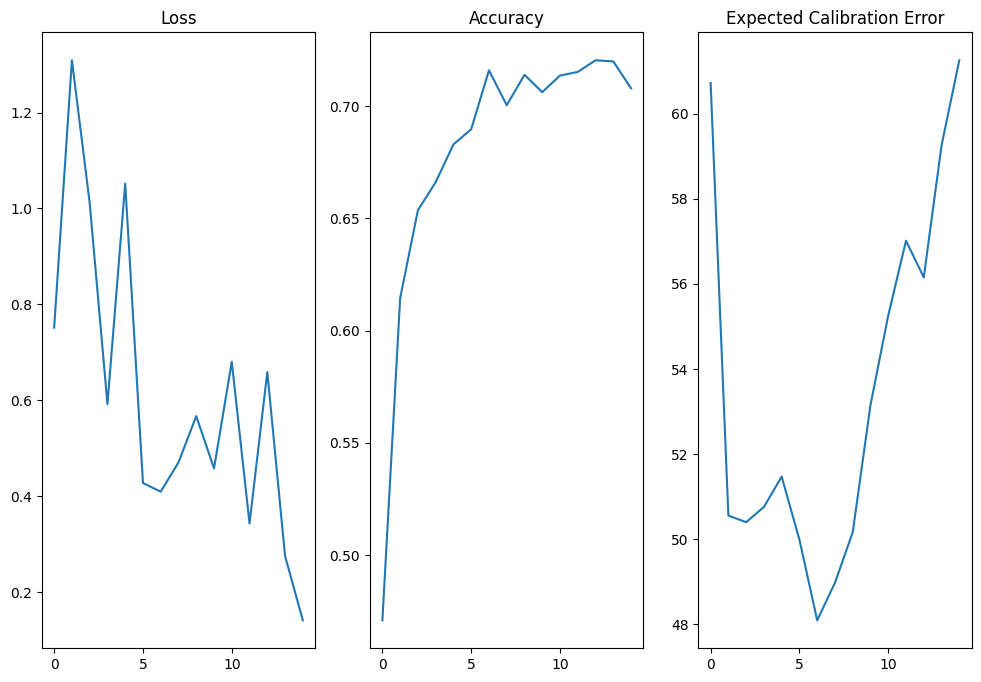

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 8))
ax[0].plot(loss_li)
ax[0].set_title('Loss')
ax[1].plot(acc_li)
ax[1].set_title('Accuracy')
ax[2].plot(epoch_error)
ax[2].set_title('Expected Calibration Error')
plt.savefig('/content/drive/MyDrive/Projects/Temperature Scaling of NN/ResNet18TrainingMetrics.jpeg', dpi=300)

In [ ]:
import pandas as pd

metrics_df = pd.DataFrame({
    'Loss':loss_li,
    'Accuracy':acc_li,
    'ECE':epoch_error
}).reset_index(drop=False).rename(columns={'index':'Epoch'})
metrics_df

,Epoch,Loss,Accuracy,ECE
0,0,0.751373,0.4709,60.719109
1,1,1.309083,0.6144,50.556511
2,2,1.011668,0.6536,50.400810
3,3,0.592049,0.6661,50.759045
4,4,1.051808,0.6829,51.471080
5,5,0.427466,0.6897,49.988702
6,6,0.409439,0.7159,48.096770
7,7,0.470487,0.7004,48.977439
8,8,0.567083,0.7139,50.164180
9,9,0.457994,0.7062,53.152571


In [ ]:
path = '/content/drive/MyDrive/Projects/Temperature Scaling of NN/ResNet18Scaled.pt'

metrics_df.to_csv('/content/drive/MyDrive/Projects/Temperature Scaling of NN/ResNet18ScaledMetrics.csv',index=False)
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, path)